In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import dataset_generation
import gcm_filtering
import gcm_filters
import os
import xrft

warnings.filterwarnings("ignore")

import aerobulk
from aerobulk import noskin

importlib.reload(dataset_generation)
from dataset_generation import preprocess_data, filter_inputs_dataset, compute_heatflux

In [3]:
from distributed import LocalCluster, Client
cluster = LocalCluster(n_workers=8, threads_per_worker=2)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/panalluri/proxy/35095/status,
Dashboard: /user/panalluri/proxy/35095/status,Workers: 8
Total threads: 16,Total memory: 125.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40827,Workers: 8
Dashboard: /user/panalluri/proxy/35095/status,Total threads: 16
Started: Just now,Total memory: 125.80 GiB
Comm: tcp://127.0.0.1:33001,Total threads: 2
Dashboard: /user/panalluri/proxy/42827/status,Memory: 15.73 GiB
Nanny: tcp://127.0.0.1:38377,


# Generate coupled dataset

In [4]:
%%time
ds_merged = preprocess_data()
ds_merged

Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind
CPU times: user 24.3 s, sys: 1.37 s, total: 25.7 s
Wall time: 32.1 s


<xarray.Dataset>
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

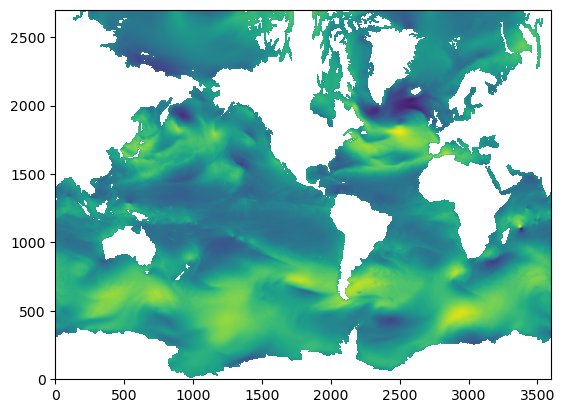

In [6]:
plt.pcolor(ds_merged.u_relative.isel(time=0))

# Filter dataset

In [5]:
%%time
print("Filtering model")
ds_out_50 = filter_inputs_dataset(ds_merged, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian', t_range=(0,730))
ds_out_50

Filtering model
CPU times: user 2.4 s, sys: 7.91 s, total: 10.3 s
Wall time: 735 ms


<xarray.Dataset>
Dimensions:       (time: 730, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time          (time) object 0181-01-01 12:00:00 ... 0182-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

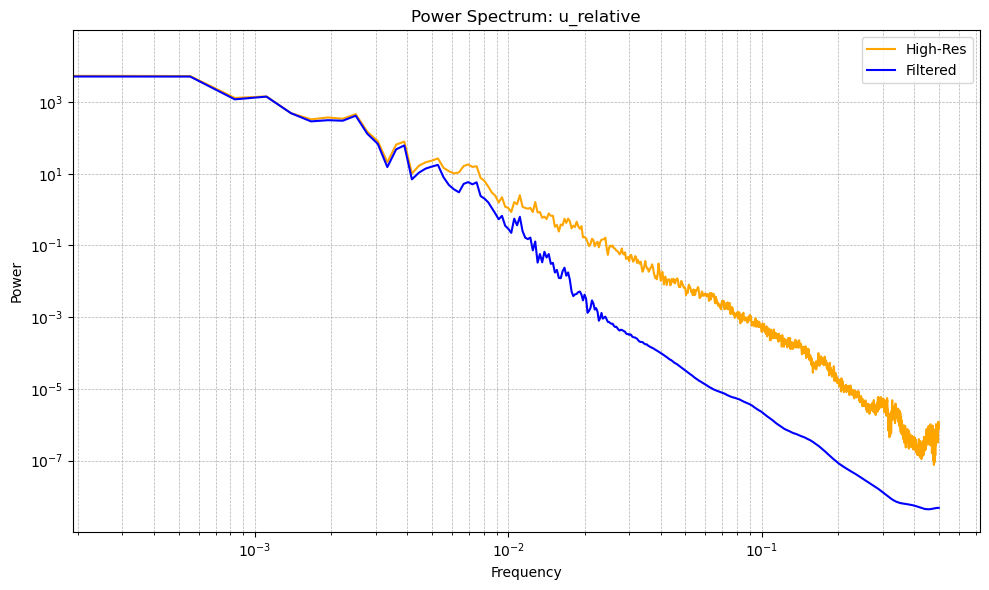

In [8]:
# Define dimensions and coordinates
dims = ['yt_ocean', 'xt_ocean']
coords = {
    'yt_ocean': range(ds_merged.u_relative.shape[-2]),
    'xt_ocean': range(ds_merged.u_relative.shape[-1])
}

# Compute averaged power spectra across samples
sample_LR = xr.DataArray(ds_out_50.u_relative.isel(time=0), dims=dims, coords=coords).chunk({'xt_ocean': -1})
ps_LR = xrft.power_spectrum(sample_LR, dim='xt_ocean', window=True).mean(dim='yt_ocean')

sample_HR = xr.DataArray(ds_merged.u_relative.isel(time=0), dims=dims, coords=coords).chunk({'xt_ocean': -1})
ps_HR = xrft.power_spectrum(sample_HR, dim='xt_ocean', window=True).mean(dim='yt_ocean')

# Plot power spectra
plt.figure(figsize=(10, 6))
plt.plot(ps_HR.freq_xt_ocean, ps_HR, label='High-Res', color='orange')
plt.plot(ps_LR.freq_xt_ocean, ps_LR, label='Filtered', color='blue')

# Configure plot
plt.title("Power Spectrum: u_relative")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.legend(loc='best')
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


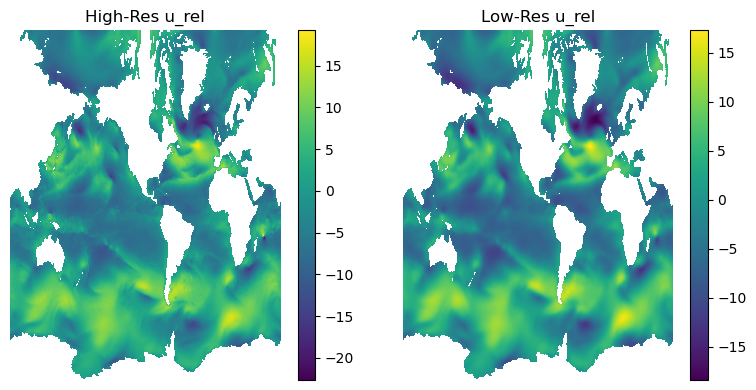

In [9]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjusted figure size

# Plot the high-resolution data
im1 = axes[0].pcolor(ds_merged.u_relative.isel(time=0))
axes[0].set_title("High-Res u_rel")
axes[0].axis('off')  # Turn off the axes
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Plot the low-resolution data
im2 = axes[1].pcolor(ds_out_50.u_relative.isel(time=0))
axes[1].set_title("Low-Res u_rel")
axes[1].axis('off')  # Turn off the axes
fig.colorbar(im2, ax=axes[1], orientation='vertical')

# Add space between subplots
plt.subplots_adjust(wspace=20)  # Increase space between plots

# Adjust layout to center the plots
plt.tight_layout()

# Show the plot
plt.show()

# Flux calculations

In [6]:
%%time
heatflux_data = compute_heatflux(ds_merged.isel(time=slice(0,730)), ds_out_50, algo='ecmwf', zt=2, zu=10)
heatflux_data

CPU times: user 307 ms, sys: 1.11 s, total: 1.42 s
Wall time: 149 ms


<xarray.Dataset>
Dimensions:        (time: 730, xt_ocean: 3600, yt_ocean: 2700)
Coordinates:
  * time           (time) object 0181-01-01 12:00:00 ... 0182-12-31 12:00:00
  * xt_ocean       (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean       (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
    dxt            (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt            (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet            (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    area_t         (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    heatflux_hr    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    heatflux_lr    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    heatflux_diff  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>

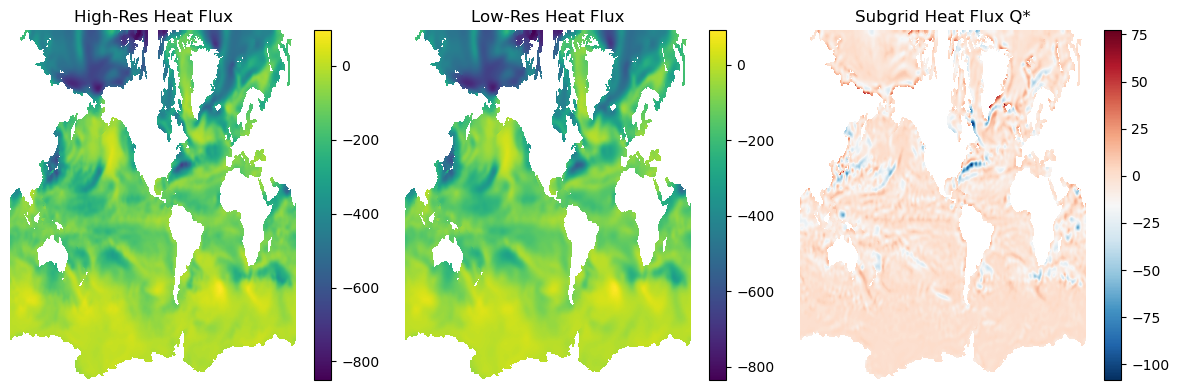

In [12]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot high-res u_relative
im1 = axes[0].pcolor(heatflux_data.heatflux_hr.isel(time=0))
axes[0].set_title("High-Res Heat Flux")
axes[0].axis("off")
fig.colorbar(im1, ax=axes[0], orientation="vertical")

# Plot low-res u_relative
im2 = axes[1].pcolor(heatflux_data.heatflux_lr.isel(time=0))
axes[1].set_title("Low-Res Heat Flux")
axes[1].axis("off")
fig.colorbar(im2, ax=axes[1], orientation="vertical")

# Plot difference with separate color scale
im3 = axes[2].pcolor(heatflux_data.heatflux_diff.isel(time=0), cmap="RdBu_r")
axes[2].set_title("Subgrid Heat Flux Q*")
axes[2].axis("off")
fig.colorbar(im3, ax=axes[2], orientation="vertical")

# Adjust spacing
plt.tight_layout()
plt.show()


# Save to zarr

Each LR timestep takes about 1.5 mins. For 730 timesteps, we're looking at ~17 hrs.

In [9]:
%%time

store_path = "gs://leap-persistent/panalluri/ds_LR.zarr"
chunk_size = 5
num_chunks = 7305 // chunk_size  # 1461
dataset = ds_out_50

for i in range(num_chunks):
    t_start = i * chunk_size
    t_end = (i + 1) * chunk_size
    ds_chunk = dataset.isel(time=slice(t_start, t_end))
    
    # Print the actual time values being written
    print(f"Chunk {i}: Writing timesteps from {t_start} to {t_end}")
    
    if i == 0:
        # First write: create the dataset
        ds_chunk.to_zarr(store_path, mode="w", compute=True, zarr_version=2)
    else:
        # Append subsequent chunks along time
        ds_chunk.to_zarr(store_path, mode="a", append_dim="time", compute=True, zarr_version=2)

Chunk 0: Writing timesteps from 0 to 5
Chunk 2: Writing timesteps from 10 to 15
Chunk 3: Writing timesteps from 15 to 20
Chunk 4: Writing timesteps from 20 to 25
Chunk 5: Writing timesteps from 25 to 30
Chunk 6: Writing timesteps from 30 to 35
Chunk 7: Writing timesteps from 35 to 40
Chunk 8: Writing timesteps from 40 to 45
Chunk 9: Writing timesteps from 45 to 50
Chunk 10: Writing timesteps from 50 to 55
Chunk 11: Writing timesteps from 55 to 60
Chunk 12: Writing timesteps from 60 to 65
Chunk 13: Writing timesteps from 65 to 70
Chunk 14: Writing timesteps from 70 to 75
Chunk 15: Writing timesteps from 75 to 80
Chunk 16: Writing timesteps from 80 to 85
Chunk 17: Writing timesteps from 85 to 90
Chunk 18: Writing timesteps from 90 to 95
Chunk 19: Writing timesteps from 95 to 100
Chunk 20: Writing timesteps from 100 to 105
Chunk 21: Writing timesteps from 105 to 110
Chunk 22: Writing timesteps from 110 to 115
Chunk 23: Writing timesteps from 115 to 120
Chunk 24: Writing timesteps from 120

ValueError: not enough values to unpack (expected 3, got 0)

In [10]:
ds_LR2Yr = xr.open_dataset(
"gs://leap-persistent/panalluri/ds_LR.zarr", engine="zarr", chunks={}
)
ds_LR2Yr

<xarray.Dataset>
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600, time: 730)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time          (time) object 0181-01-01 12:00:00 ... 0182-12-31 12:00:00
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

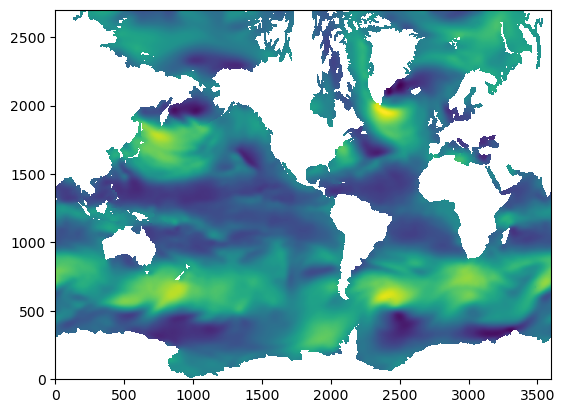

In [12]:
plt.pcolor(ds_LR2Yr.u_relative.isel(time=729))

In [32]:
ds_HR2Yr = xr.open_dataset(
"gs://leap-persistent/panalluri/ds_HR.zarr", engine="zarr", chunks={}
)
ds_HR2Yr

<xarray.Dataset>
Dimensions:       (yt_ocean: 2700, xt_ocean: 3600, time: 730)
Coordinates:
    area_t        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time          (time) object 0181-01-01 12:00:00 ... 0182-12-31 12:00:00
    wet           (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean      (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean      (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    q_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    rh_ref        (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    slp           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

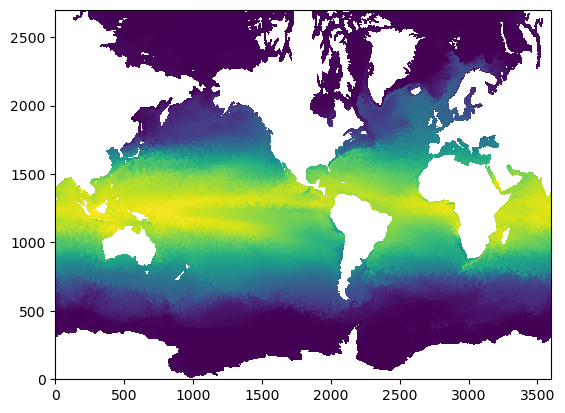

In [35]:
plt.pcolor(ds_HR2Yr.surface_temp.isel(time=700))

In [7]:
ds_HF2Yr = xr.open_dataset(
"gs://leap-persistent/panalluri/ds_HF.zarr", engine="zarr", chunks={}
)
ds_HF2Yr

<xarray.Dataset>
Dimensions:        (yt_ocean: 2700, xt_ocean: 3600, time: 730)
Coordinates:
    area_t         (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt            (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt            (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht             (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time           (time) object 0181-01-01 12:00:00 ... 0182-12-31 12:00:00
    wet            (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean       (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean       (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    heatflux_diff  (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    heatflux_hr    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    heatflux_lr    (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>

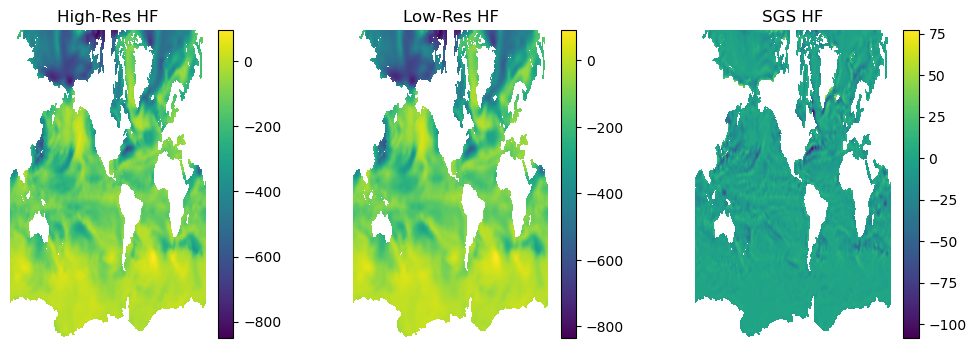

In [8]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # Adjusted for 3 plots

# Plot 1: High-resolution
im1 = axes[0].pcolor(ds_HF2Yr.heatflux_hr.isel(time=0))
axes[0].set_title("High-Res HF")
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], orientation='vertical')

# Plot 2: Low-resolution
im2 = axes[1].pcolor(ds_HF2Yr.heatflux_lr.isel(time=0))
axes[1].set_title("Low-Res HF")
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], orientation='vertical')

# Plot 3: Super-resolved (or another dataset of your choice)
im3 = axes[2].pcolor(ds_HF2Yr.heatflux_diff.isel(time=0))  # <- make sure ds_sr exists
axes[2].set_title("SGS HF")
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2], orientation='vertical')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plot
plt.show()
